# Определение стоимости автомобилей
# Задачи
Разработка системы рекомендации стоимости автомобиля на основе его описания
# Описание проекта
Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторические данные необходимо построить модель для определения стоимости автомобиля.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor, Pool
import time 

In [3]:
data = pd.read_csv('autos.csv')
# для запуска на платформе
#data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Проверим дибликаты

In [6]:
data.duplicated().sum()

4

In [7]:
data = data.drop_duplicates().reset_index(drop=True) 

### Обработка пропусков

В столбцах 'Repaired', 'Model' пропуски заполним на новую категорию 'nd', то есть не определено. А пропуски в следующих категориальных столбцах 'VehicleType', 'Gearbox', 'FuelType' заполним как моды по модели автомобиля.

In [8]:
def fill_mode(data, onwhat, what):
    for f in data[onwhat].unique():
        data.loc[(data[onwhat] == f) &(data[what].isna()), what] = data.loc[(data[onwhat] == f), what].mode().values[0]
    return data[what].isna().sum()

In [9]:
data['Repaired'] = data['Repaired'].fillna('nd')
data['Model'] = data['Model'].fillna('nd')
fill_mode(data, 'Model', 'VehicleType')
fill_mode(data, 'Model', 'Gearbox')
fill_mode(data, 'Model', 'FuelType')

0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

### Обработка выбросов и аномальных значений

Можем заметить, что в данных есть выбросы. В столбце RegistrationYear вообще есть нереальные значения, посмотрим, как этот столбец ведет себя в зависимости от даты выгрузки анкет. 

<AxesSubplot:>

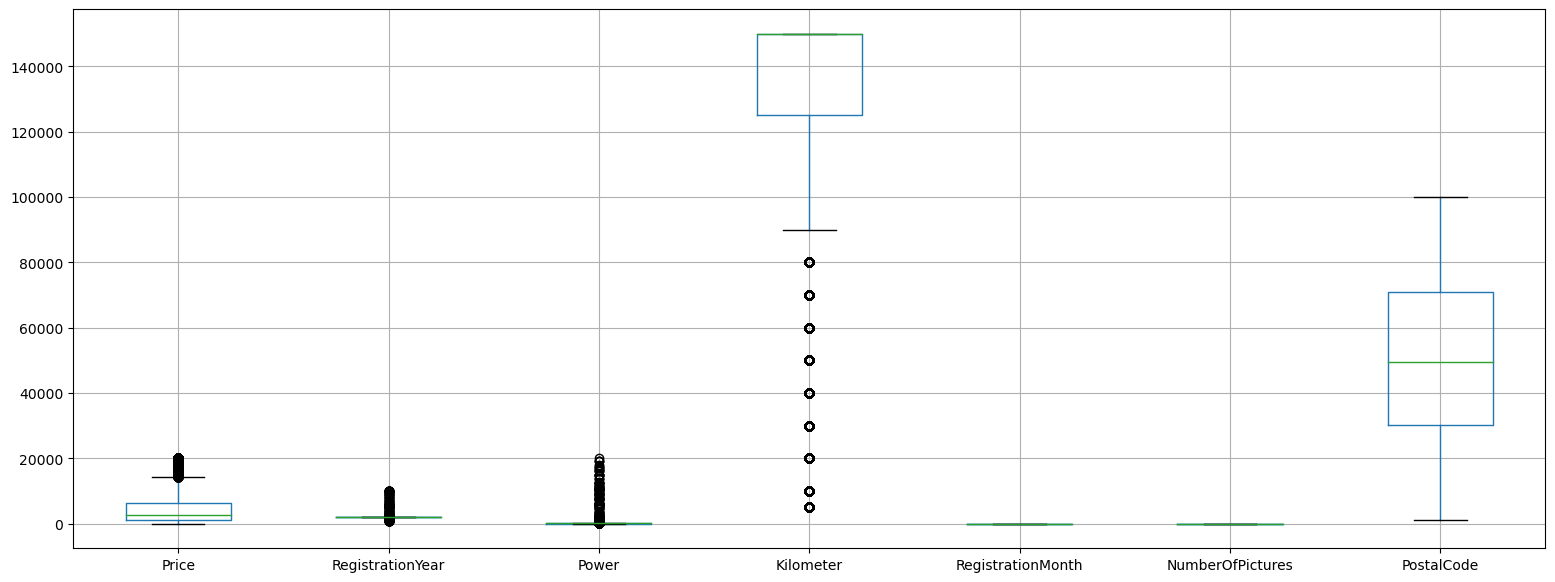

In [11]:
data.boxplot(figsize=(19, 7))

In [12]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

In [13]:
data['RegistrationYear'].sort_values().value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
2900        1
3200        1
3500        1
3700        1
1255        1
Name: RegistrationYear, Length: 151, dtype: int64

Посторим график изменения RegistrationYear в зависимости от даты выгрузки анкеты DateCrawled. Можем заметить, что в среднем дата регистрации большинства машин лежит в диапозоне от 2002 - 2004 года.

In [14]:
m = data[['DateCrawled', 'RegistrationYear']]
m.index = m['DateCrawled']
m = m.drop('DateCrawled', axis=1)
m.sort_index(inplace=True)
m = m.resample('1h').median()
m['rolling_mean'] = m.rolling(10).mean()
m.plot(figsize=(10,7))

<AxesSubplot:xlabel='DateCrawled'>

Но если мы оставим машины с годом регистрации в диапазоне 2002-2004, то потеряем много данных, поэтому избавимся от выбросов в RegistrationYear с помощью межквартильного диапозона

In [15]:
def clean(column):
    q1 = column.quantile(q=.25)
    q3 = column.quantile(q=.75)
    iqr = q3 - q1
    max_v = q1-1.5*iqr
    min_v = q3+1.5*iqr
    return max_v, min_v

In [16]:
columns=['RegistrationYear']
for i in columns:
    data = data[~((data[i]< clean(data[i])[0])| \
              (data[i]> clean(data[i])[1]))]

In [17]:
data['RegistrationYear'].describe()

count    348056.000000
mean       2003.586523
std           6.373410
min        1986.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [18]:
data.boxplot(figsize=(19, 7))

<AxesSubplot:xlabel='DateCrawled'>

Теперь посмоотрим на данные в столбце мощности двигателя. Средняя мощность двигателя автомобиля обычно составляет 137,1 л.с., а в наших данных минимальная мощность двигателя = 0. Поэтому возьмем нижнюю границу мощности чуть ниже средней - 100л.с. и отфильтруем данные.

In [19]:
data['Power'].describe()

count    348056.000000
mean        110.694518
std         188.893320
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [20]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,nd,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nd,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nd,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,sedan,2005,manual,0,nd,20000,1,petrol,sonstige_autos,nd,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [21]:
data = data.query('Power >=100')

In [22]:
data['Power'].describe()

count    198257.000000
mean        154.445543
std         239.482286
min         100.000000
25%         115.000000
50%         140.000000
75%         170.000000
max       20000.000000
Name: Power, dtype: float64

Также есть аномальные значения в данных о цене автомобилей. Например, обьявления, в которых машиины отдают задаром. Поэтому поставим нижнюю границу цены - больше нуля

In [23]:
data = data[data['Price']>0]

In [24]:
data['Price'].describe()

count    194249.000000
mean       6056.945971
std        4933.998735
min           1.000000
25%        2000.000000
50%        4500.000000
75%        8900.000000
max       20000.000000
Name: Price, dtype: float64

### Удаление неинформативных признаков
Удалим признаки, связанные с работой платформы, дату выгрузки, регистрации, создания обьявления, количество картинок и тд.

In [25]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', \
                          'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])

Посмотрим коррелируют ли между сообой признаки

In [26]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.561305,0.066471,-0.461843
RegistrationYear,0.561305,1.000000,0.004511,-0.353502
Power,0.066471,0.004511,1.000000,-0.001811
Kilometer,-0.461843,-0.353502,-0.001811,1.000000


### Вывод
На этапе обработки данных были заполнены пропуски в категориальных переменных, в численных переменных пропусков не было. В столбцах 'Repaired', 'Model' пропуски заполним на новую категорию 'nd', то есть не определено. А пропуски в следующих категориальных столбцах 'VehicleType', 'Gearbox', 'FuelType' заполним как моды по категории модели автомобиля. Также избавиись от дубликатов. Можем заметить, что в данных есть выбросы. В столбце RegistrationYear вообще есть аномальные значения. Построили график изменения года регистрации автомобиля в зависимости от даты выгрузки анкеты DateCrawled. Можем заметить, что в среднем дата регистрации большинства машин лежит в диапозоне от 2002 - 2004 года. Но если мы оставим машины с годом регистрации в диапазоне 2002-2004, то потеряем много данных, поэтому избавимся от выбросов в RegistrationYear с помощью межквартильного диапозона. Аномальные низкие значения также были замечены в столбце мощности двигателя 'Power'. Средняя мощность двигателя автомобиля обычно составляет 137,1 л.с., а в наших данных минимальная мощность двигателя = 0. Поэтому возьмем нижнюю границу мощности чуть ниже средней - 100л.с. и отфильтруем данные. Аналогично поступили и в случае цены автомобиля - значения в стобце 'Price' теперь не могут быть ниже нуля. Также для обучения моделей и прдесказывания данных нам следует удолить неинформативные столбцы, что и было сделано. Были удалены признаки, связанные с работой платформы, дату выгрузки, регистрации, создания обьявления, количество картинок и тд.

## Обучение моделей

In [27]:
target = data['Price']
features = data.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, \
                                                                            random_state=12345)

In [28]:
categories = features_train.select_dtypes(include='object').columns.to_list()
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=np.nan)
enc.fit(features_train[categories])
X_enc = enc.transform(features_train[categories])
features_train_cat = pd.DataFrame(X_enc, columns=categories, index=features_train.index)
num_feauters = features_train.drop(categories, axis=1)
enc_feauters_train = pd.concat([num_feauters, features_train_cat], axis=1)

In [29]:
features_test_enc = enc.transform(features_test[categories])
features_test_cat = pd.DataFrame(features_test_enc, columns=categories, index=features_test.index)
num_feauters_t = features_test.drop(categories, axis=1)
enc_features_test = pd.concat([num_feauters_t, features_test_cat], axis=1)

In [30]:
enc_features_test

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
168163,2010,140,150000,7.0,0.0,146.0,2.0,10.0,1.0
163673,2004,101,125000,5.0,1.0,97.0,6.0,31.0,0.0
350715,2008,140,150000,7.0,0.0,160.0,2.0,37.0,1.0
174403,2005,224,150000,7.0,0.0,30.0,2.0,1.0,1.0
85417,2000,135,150000,7.0,1.0,11.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
107311,1998,101,5000,5.0,1.0,112.0,6.0,37.0,1.0
190502,2001,170,150000,4.0,1.0,92.0,2.0,20.0,1.0
349355,1999,279,150000,7.0,0.0,92.0,6.0,20.0,1.0
191721,2012,132,60000,4.0,1.0,42.0,6.0,36.0,1.0


In [31]:
def scaling(features_train, features_test):
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = pd.DataFrame(scaler.transform(features_train), columns = features_train.columns, index =features_train.index)
    features_test = pd.DataFrame(scaler.fit_transform(features_test),columns = features_test.columns, index =features_test.index )
    
    return features_train, features_test

In [32]:
enc_feauters_train, enc_features_test = scaling(enc_feauters_train, enc_features_test)

### Linear Regression

In [33]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]} 
model_lr = SGDRegressor(tol=.0001) 
n_iter_search = 8 
r_s_lr = RandomizedSearchCV(model_lr, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   cv=3, 
                                   scoring='neg_mean_squared_error') 
r_s_lr.fit(enc_feauters_train, target_train) 

RandomizedSearchCV(cv=3, estimator=SGDRegressor(tol=0.0001), n_iter=8,
                   param_distributions={'eta0': [0.001, 0.003, 0.01, 0.03, 0.1,
                                                 0.3, 1, 3]},
                   scoring='neg_mean_squared_error')

In [34]:
r_s_lr.best_params_

{'eta0': 0.003}

In [35]:
rmse_lr = abs(r_s_lr.best_score_)**0.5
rmse_lr

3594.8433547916843

In [36]:
r_s_lr.cv_results_

{'mean_fit_time': array([0.09894935, 0.07782324, 0.14183076, 0.16460435, 0.14562337,
        0.05483317, 0.09533922, 0.05463529]),
 'std_fit_time': array([8.14522945e-03, 1.42935495e-02, 2.83800874e-02, 3.50659141e-02,
        5.48841121e-02, 5.61116363e-03, 3.24022034e-02, 6.84390073e-06]),
 'mean_score_time': array([0.00186022, 0.00109935, 0.00119074, 0.00134762, 0.00131869,
        0.00107535, 0.00122444, 0.00102933]),
 'std_score_time': array([9.41755527e-04, 4.90752470e-05, 4.35788178e-05, 2.12507901e-04,
        2.15651944e-04, 4.14612278e-05, 2.52989888e-04, 1.19532042e-05]),
 'param_eta0': masked_array(data=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.001},
  {'eta0': 0.003},
  {'eta0': 0.01},
  {'eta0': 0.03},
  {'eta0': 0.1},
  {'eta0': 0.3},
  {'eta0': 1},
  {'eta0': 3}],
 'split0_test_score': array([-1.28730134e+07, -1.284727

In [37]:
print('Время обучения для модели SGDRegressor:', r_s_lr.cv_results_['mean_fit_time'][1])
print('Время предсказания для модели SGDRegressor:', r_s_lr.cv_results_['mean_score_time'][1])
print('RMSE для модели SGDRegressor:', rmse_lr)

Время обучения для модели SGDRegressor: 0.07782324155171712
Время предсказания для модели SGDRegressor: 0.0010993480682373047
RMSE для модели SGDRegressor: 3594.8433547916843


### RandomForestRegressor

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)]
max_depth = [2,4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [39]:
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
model_rf = RandomForestRegressor(random_state=12345)
rs = RandomizedSearchCV(model_rf, 
                        param_distributions = param_grid, 
                        cv = 10, scoring = 'neg_mean_squared_error',
                        random_state=12345)
rs.fit(enc_feauters_train, target_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'min_samples_leaf': [1, 2],
                                        'n_estimators': [10, 14, 19, 24, 28, 33,
                                                         38, 43, 47, 52, 57, 62,
                                                         66, 71, 76, 81, 85, 90,
                                                         95, 100]},
                   random_state=12345, scoring='neg_mean_squared_error')

In [41]:
rs.best_params_

{'n_estimators': 43, 'min_samples_leaf': 2, 'max_depth': 4, 'bootstrap': True}

In [43]:
rmse_rf = rs.best_score_
rmse_rf = abs(rmse_rf)**0.5
rmse_rf

2807.414749054385

In [44]:
rf_cv_results = pd.DataFrame(rs.cv_results_)
rf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.482807,0.015246,0.016198,0.000146,66,1,2,False,"{'n_estimators': 66, 'min_samples_leaf': 1, 'm...",-1.269710e+07,...,-1.278619e+07,-1.259711e+07,-1.228030e+07,-1.235171e+07,-1.258991e+07,-1.241829e+07,-1.279078e+07,-1.254267e+07,175402.184225,9
1,2.842338,0.012617,0.023942,0.000160,100,2,2,True,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",-1.260508e+07,...,-1.274398e+07,-1.241187e+07,-1.212586e+07,-1.215687e+07,-1.251512e+07,-1.221998e+07,-1.266497e+07,-1.240619e+07,208710.658593,7
2,0.902777,0.006922,0.006592,0.000085,24,2,2,False,"{'n_estimators': 24, 'min_samples_leaf': 2, 'm...",-1.269710e+07,...,-1.278619e+07,-1.259711e+07,-1.228030e+07,-1.235171e+07,-1.258991e+07,-1.241829e+07,-1.279078e+07,-1.254267e+07,175402.184225,9
3,2.388250,0.010033,0.020061,0.000380,47,1,4,True,"{'n_estimators': 47, 'min_samples_leaf': 1, 'm...",-7.963047e+06,...,-8.279433e+06,-7.880204e+06,-7.491235e+06,-7.817957e+06,-7.957666e+06,-7.796921e+06,-7.979064e+06,-7.884923e+06,196021.926836,2
4,1.721036,0.006693,0.010548,0.000096,24,2,4,False,"{'n_estimators': 24, 'min_samples_leaf': 2, 'm...",-8.216319e+06,...,-8.488864e+06,-8.130063e+06,-7.805961e+06,-8.091197e+06,-8.182786e+06,-8.010776e+06,-8.227339e+06,-8.139245e+06,179090.175637,4
5,3.343469,0.029814,0.027366,0.000408,66,1,4,True,"{'n_estimators': 66, 'min_samples_leaf': 1, 'm...",-7.985598e+06,...,-8.314215e+06,-7.891478e+06,-7.546454e+06,-7.822251e+06,-7.961054e+06,-7.796740e+06,-7.998651e+06,-7.907561e+06,193406.927551,3
6,2.168768,0.010237,0.018132,0.000073,43,2,4,True,"{'n_estimators': 43, 'min_samples_leaf': 2, 'm...",-7.962536e+06,...,-8.270388e+06,-7.869250e+06,-7.496751e+06,-7.821418e+06,-7.945820e+06,-7.802161e+06,-7.988569e+06,-7.881578e+06,193341.257413,1
7,2.009272,0.027325,0.012072,0.000096,28,2,4,False,"{'n_estimators': 28, 'min_samples_leaf': 2, 'm...",-8.216319e+06,...,-8.488864e+06,-8.130063e+06,-7.805961e+06,-8.091197e+06,-8.182786e+06,-8.010776e+06,-8.227339e+06,-8.139245e+06,179090.175637,4
8,2.323831,0.051136,0.019709,0.000218,81,2,2,True,"{'n_estimators': 81, 'min_samples_leaf': 2, 'm...",-1.265078e+07,...,-1.274370e+07,-1.243575e+07,-1.215722e+07,-1.215061e+07,-1.252794e+07,-1.222856e+07,-1.266664e+07,-1.242752e+07,206857.387872,8
9,4.730705,0.040628,0.026926,0.000230,66,1,4,False,"{'n_estimators': 66, 'min_samples_leaf': 1, 'm...",-8.216319e+06,...,-8.488864e+06,-8.130063e+06,-7.805961e+06,-8.091197e+06,-8.182786e+06,-8.010776e+06,-8.227339e+06,-8.139245e+06,179090.175637,4


In [45]:
print('Время обучения для модели Random Forest:', rf_cv_results[rf_cv_results['rank_test_score'] == 1]['mean_fit_time'].values[0])
print('Время предсказания для модели Random Forest:', rf_cv_results[rf_cv_results['rank_test_score']==1]['mean_score_time'].values[0])
print('RMSE для модели Random Forest:', rmse_rf)

Время обучения для модели Random Forest: 2.168768072128296
Время предсказания для модели Random Forest: 0.018131589889526366
RMSE для модели Random Forest: 2807.414749054385


### Lightgbm

In [46]:
categories = features_train.select_dtypes(include='object').columns.to_list()
features_train[categories] = features_train[categories].astype('category')
features_test[categories] = features_test[categories].astype('category')

In [47]:

param_grid = {
    'learning_rate': [0.1, 0.01, 0.3],
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 12]
}
estimator = lgb.LGBMRegressor(objective='regression', 
                              random_state=12345)

model_lgbm = GridSearchCV(estimator=estimator, 
                     param_grid=param_grid,
                     cv=3, 
                     n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')

model_lgbm.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression',
                                     random_state=12345),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.3],
                         'max_depth': [3, 6, 12], 'n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error')

In [48]:
model_lgbm.best_estimator_

LGBMRegressor(learning_rate=0.3, max_depth=12, objective='regression',
              random_state=12345)

In [49]:
model_lgbm.best_params_

{'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 100}

In [50]:
rmse_lgbm = abs(model_lgbm.best_score_)

In [51]:
model_lgbm.cv_results_

{'mean_fit_time': array([0.4387188 , 0.65157835, 0.54654121, 0.8488435 , 0.57839306,
        0.92338371, 0.42197243, 0.61640549, 0.50894841, 0.89485598,
        0.51196798, 0.90054099, 0.29136737, 0.43533635, 0.41475145,
        0.63825957, 0.41159972, 0.50057459]),
 'std_fit_time': array([0.00340501, 0.08099525, 0.03146342, 0.0309715 , 0.00858124,
        0.02510013, 0.04777053, 0.0496628 , 0.02068314, 0.0324399 ,
        0.01641207, 0.01784086, 0.00524346, 0.00865246, 0.00507848,
        0.04375014, 0.00989771, 0.04784732]),
 'mean_score_time': array([0.09791795, 0.21645395, 0.21257703, 0.51241573, 0.23848192,
        0.46784353, 0.09710352, 0.14865653, 0.13131293, 0.35626411,
        0.13012401, 0.34618608, 0.08647442, 0.18072383, 0.15505052,
        0.27434897, 0.1388003 , 0.18263316]),
 'std_score_time': array([0.01529262, 0.01428251, 0.01157291, 0.02725526, 0.0194406 ,
        0.03296039, 0.0076259 , 0.00557754, 0.00675975, 0.00822616,
        0.00174435, 0.0089548 , 0.01441216, 

In [52]:
print('Время обучения для модели LightGBM:', model_lgbm.cv_results_['mean_fit_time'][-1])
print('Время предсказания для модели LightGBM:', model_lgbm.cv_results_['mean_score_time'][-1])
print('RMSE для модели LightGBM:', rmse_lgbm)

Время обучения для модели LightGBM: 0.5005745887756348
Время предсказания для модели LightGBM: 0.1826331615447998
RMSE для модели LightGBM: 1810.964747121592


### Catboost

In [53]:
categories

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [54]:
pool_train = Pool(features_train, target_train, cat_features = categories)

pool_test = Pool(features_test, cat_features = categories)

In [55]:

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6]
       }

r_s_catboost = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=3, n_jobs=-1, \
                                  scoring='neg_root_mean_squared_error')
r_s_catboost.fit(features_train, target_train, cat_features = categories)

/Users/dariaurova/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 4846.9655051	total: 200ms	remaining: 3m 19s
1:	learn: 4765.7072110	total: 338ms	remaining: 2m 48s
2:	learn: 4686.2674098	total: 479ms	remaining: 2m 39s
3:	learn: 4611.4038340	total: 582ms	remaining: 2m 24s
4:	learn: 4539.9276639	total: 667ms	remaining: 2m 12s
5:	learn: 4469.5766518	total: 741ms	remaining: 2m 2s
6:	learn: 4399.2730674	total: 848ms	remaining: 2m
7:	learn: 4330.6956161	total: 974ms	remaining: 2m
8:	learn: 4267.0468604	total: 1.1s	remaining: 2m
9:	learn: 4204.5345701	total: 1.19s	remaining: 1m 57s
10:	learn: 4146.2286578	total: 1.25s	remaining: 1m 52s
11:	learn: 4088.8806091	total: 1.36s	remaining: 1m 51s
12:	learn: 4033.9054615	total: 1.46s	remaining: 1m 50s
13:	learn: 3979.9554186	total: 1.59s	remaining: 1m 51s
14:	learn: 3930.1046912	total: 1.67s	remaining: 1m 49s
15:	learn: 3880.3831884	total: 1.8s	remaining: 1m 50s
16:	learn: 3827.6976213	total: 1.89s	remaining: 1m 49s
17:	learn: 3778.7568667	total: 1.95s	remaining: 1m 46s
18:	learn: 3732.1283310	total: 2s	r

0:	learn: 4827.8538118	total: 173ms	remaining: 2m 52s
1:	learn: 4747.2374805	total: 317ms	remaining: 2m 38s
2:	learn: 4668.4533354	total: 413ms	remaining: 2m 17s
3:	learn: 4593.9282142	total: 531ms	remaining: 2m 12s
4:	learn: 4521.9713480	total: 630ms	remaining: 2m 5s
5:	learn: 4452.6667163	total: 743ms	remaining: 2m 3s
6:	learn: 4383.1550092	total: 846ms	remaining: 2m
7:	learn: 4316.3030936	total: 1.03s	remaining: 2m 8s
8:	learn: 4254.5207729	total: 1.11s	remaining: 2m 2s
9:	learn: 4191.1699003	total: 1.21s	remaining: 2m
10:	learn: 4131.9900197	total: 1.32s	remaining: 1m 59s
11:	learn: 4074.4276797	total: 1.41s	remaining: 1m 56s
12:	learn: 4019.0691423	total: 1.52s	remaining: 1m 55s
13:	learn: 3965.2088771	total: 1.63s	remaining: 1m 54s
14:	learn: 3915.7417965	total: 1.71s	remaining: 1m 52s
15:	learn: 3866.3504655	total: 1.83s	remaining: 1m 52s
16:	learn: 3814.1082269	total: 1.89s	remaining: 1m 49s
17:	learn: 3765.6893566	total: 1.99s	remaining: 1m 48s
18:	learn: 3721.6235506	total: 2

0:	learn: 4634.8645257	total: 205ms	remaining: 3m 25s
1:	learn: 4393.6348418	total: 347ms	remaining: 2m 52s
2:	learn: 4181.4817455	total: 480ms	remaining: 2m 39s
3:	learn: 3981.3812545	total: 578ms	remaining: 2m 23s
4:	learn: 3813.0658999	total: 672ms	remaining: 2m 13s
5:	learn: 3653.8897778	total: 788ms	remaining: 2m 10s
6:	learn: 3524.0050537	total: 886ms	remaining: 2m 5s
7:	learn: 3395.7171033	total: 987ms	remaining: 2m 2s
8:	learn: 3291.8355047	total: 1.09s	remaining: 2m
9:	learn: 3186.1520302	total: 1.19s	remaining: 1m 57s
10:	learn: 3104.7158970	total: 1.25s	remaining: 1m 52s
11:	learn: 3024.8608793	total: 1.38s	remaining: 1m 53s
12:	learn: 2958.0069568	total: 1.47s	remaining: 1m 51s
13:	learn: 2903.0489278	total: 1.55s	remaining: 1m 48s
14:	learn: 2843.9319237	total: 1.64s	remaining: 1m 47s
15:	learn: 2798.3740572	total: 1.75s	remaining: 1m 47s
16:	learn: 2755.9248521	total: 1.8s	remaining: 1m 44s
17:	learn: 2709.6243825	total: 1.88s	remaining: 1m 42s
18:	learn: 2667.9535616	tot

0:	learn: 4846.5819782	total: 207ms	remaining: 3m 26s
1:	learn: 4764.7654662	total: 350ms	remaining: 2m 54s
2:	learn: 4685.2149964	total: 479ms	remaining: 2m 39s
3:	learn: 4609.9296472	total: 610ms	remaining: 2m 31s
4:	learn: 4536.5427990	total: 720ms	remaining: 2m 23s
5:	learn: 4466.2324764	total: 803ms	remaining: 2m 13s
6:	learn: 4395.7730850	total: 945ms	remaining: 2m 14s
7:	learn: 4326.9952726	total: 1.06s	remaining: 2m 11s
8:	learn: 4264.4631478	total: 1.14s	remaining: 2m 4s
9:	learn: 4201.9859903	total: 1.25s	remaining: 2m 3s
10:	learn: 4142.3685424	total: 1.34s	remaining: 2m
11:	learn: 4084.8664970	total: 1.43s	remaining: 1m 57s
12:	learn: 4029.7306587	total: 1.54s	remaining: 1m 56s
13:	learn: 3975.8482326	total: 1.67s	remaining: 1m 57s
14:	learn: 3925.3385850	total: 1.74s	remaining: 1m 54s
15:	learn: 3873.0648787	total: 1.84s	remaining: 1m 53s
16:	learn: 3820.0358393	total: 1.92s	remaining: 1m 51s
17:	learn: 3771.0744605	total: 2.01s	remaining: 1m 49s
18:	learn: 3725.9999944	to

0:	learn: 4842.4532182	total: 309ms	remaining: 5m 8s
1:	learn: 4751.4457412	total: 462ms	remaining: 3m 50s
2:	learn: 4664.3766458	total: 619ms	remaining: 3m 25s
3:	learn: 4579.1791202	total: 767ms	remaining: 3m 11s
4:	learn: 4498.7855325	total: 939ms	remaining: 3m 6s
5:	learn: 4419.0688289	total: 1.09s	remaining: 3m 1s
6:	learn: 4343.8993675	total: 1.24s	remaining: 2m 55s
7:	learn: 4267.7890503	total: 1.37s	remaining: 2m 50s
8:	learn: 4194.3044000	total: 1.56s	remaining: 2m 51s
9:	learn: 4126.4211457	total: 1.67s	remaining: 2m 45s
10:	learn: 4060.3123221	total: 1.8s	remaining: 2m 42s
11:	learn: 3993.6670371	total: 1.95s	remaining: 2m 40s
12:	learn: 3933.3143257	total: 2.05s	remaining: 2m 35s
13:	learn: 3874.2284414	total: 2.15s	remaining: 2m 31s
14:	learn: 3813.1734321	total: 2.29s	remaining: 2m 30s
15:	learn: 3757.3294640	total: 2.39s	remaining: 2m 27s
16:	learn: 3699.6282508	total: 2.48s	remaining: 2m 23s
17:	learn: 3644.4479195	total: 2.59s	remaining: 2m 21s
18:	learn: 3593.8694923	

0:	learn: 4842.1733305	total: 256ms	remaining: 4m 16s
1:	learn: 4751.2555940	total: 446ms	remaining: 3m 42s
2:	learn: 4661.7864206	total: 611ms	remaining: 3m 23s
3:	learn: 4573.9752435	total: 750ms	remaining: 3m 6s
4:	learn: 4492.1134722	total: 924ms	remaining: 3m 3s
5:	learn: 4413.1047025	total: 1.09s	remaining: 3m 1s
6:	learn: 4337.4494837	total: 1.24s	remaining: 2m 55s
7:	learn: 4264.1279027	total: 1.39s	remaining: 2m 52s
8:	learn: 4190.7294207	total: 1.5s	remaining: 2m 45s
9:	learn: 4123.3096088	total: 1.65s	remaining: 2m 43s
10:	learn: 4059.6697009	total: 1.77s	remaining: 2m 39s
11:	learn: 3996.1880690	total: 1.87s	remaining: 2m 34s
12:	learn: 3934.3061985	total: 1.95s	remaining: 2m 27s
13:	learn: 3870.1386874	total: 2.06s	remaining: 2m 25s
14:	learn: 3812.9327259	total: 2.18s	remaining: 2m 23s
15:	learn: 3754.3127267	total: 2.3s	remaining: 2m 21s
16:	learn: 3701.9526757	total: 2.39s	remaining: 2m 18s
17:	learn: 3645.8413410	total: 2.49s	remaining: 2m 15s
18:	learn: 3596.3886114	t

301:	learn: 2131.9972073	total: 22.2s	remaining: 51.4s
302:	learn: 2131.6217360	total: 22.3s	remaining: 51.4s
303:	learn: 2131.1077439	total: 22.4s	remaining: 51.3s
304:	learn: 2130.8196000	total: 22.5s	remaining: 51.3s
305:	learn: 2130.2917653	total: 22.6s	remaining: 51.2s
306:	learn: 2129.9545867	total: 22.6s	remaining: 51.1s
307:	learn: 2129.3633530	total: 22.7s	remaining: 51s
308:	learn: 2128.4838943	total: 22.7s	remaining: 50.8s
309:	learn: 2128.0486295	total: 22.8s	remaining: 50.8s
310:	learn: 2127.7347930	total: 22.9s	remaining: 50.7s
311:	learn: 2126.6707868	total: 23s	remaining: 50.6s
312:	learn: 2125.7552038	total: 23s	remaining: 50.6s
313:	learn: 2125.3832342	total: 23.1s	remaining: 50.5s
314:	learn: 2124.7163246	total: 23.2s	remaining: 50.4s
315:	learn: 2124.3201082	total: 23.3s	remaining: 50.3s
316:	learn: 2123.2410975	total: 23.3s	remaining: 50.2s
317:	learn: 2122.9993735	total: 23.4s	remaining: 50.2s
318:	learn: 2122.7705150	total: 23.5s	remaining: 50.1s
319:	learn: 2121

299:	learn: 2140.8556655	total: 22.3s	remaining: 52s
300:	learn: 2140.4788053	total: 22.4s	remaining: 51.9s
301:	learn: 2139.9464170	total: 22.4s	remaining: 51.8s
302:	learn: 2139.1891628	total: 22.5s	remaining: 51.7s
303:	learn: 2138.8876846	total: 22.5s	remaining: 51.6s
304:	learn: 2138.4845322	total: 22.6s	remaining: 51.5s
305:	learn: 2137.8895052	total: 22.7s	remaining: 51.4s
306:	learn: 2137.3733002	total: 22.8s	remaining: 51.4s
307:	learn: 2136.9223716	total: 22.8s	remaining: 51.3s
308:	learn: 2136.6682617	total: 22.9s	remaining: 51.3s
309:	learn: 2136.2696005	total: 23s	remaining: 51.3s
310:	learn: 2135.5334423	total: 23.1s	remaining: 51.3s
311:	learn: 2134.9399187	total: 23.2s	remaining: 51.2s
312:	learn: 2134.6383944	total: 23.3s	remaining: 51.1s
313:	learn: 2134.2488235	total: 23.4s	remaining: 51s
314:	learn: 2133.8315608	total: 23.5s	remaining: 51s
315:	learn: 2133.4766798	total: 23.5s	remaining: 50.9s
316:	learn: 2132.6508701	total: 23.6s	remaining: 50.9s
317:	learn: 2132.3

299:	learn: 1968.7486144	total: 22.9s	remaining: 53.5s
300:	learn: 1968.4753967	total: 23s	remaining: 53.4s
301:	learn: 1968.1583881	total: 23.1s	remaining: 53.3s
302:	learn: 1967.5543484	total: 23.1s	remaining: 53.3s
303:	learn: 1967.3027590	total: 23.2s	remaining: 53.1s
304:	learn: 1966.9380422	total: 23.3s	remaining: 53.1s
305:	learn: 1966.5390718	total: 23.4s	remaining: 53s
306:	learn: 1965.9640510	total: 23.4s	remaining: 52.9s
307:	learn: 1965.4398861	total: 23.5s	remaining: 52.9s
308:	learn: 1964.9403019	total: 23.6s	remaining: 52.8s
309:	learn: 1964.1954220	total: 23.7s	remaining: 52.8s
310:	learn: 1963.8827437	total: 23.8s	remaining: 52.7s
311:	learn: 1963.6794721	total: 23.9s	remaining: 52.7s
312:	learn: 1963.4909714	total: 23.9s	remaining: 52.5s
313:	learn: 1963.1085198	total: 24s	remaining: 52.5s
314:	learn: 1962.9882424	total: 24.1s	remaining: 52.4s
315:	learn: 1962.8407204	total: 24.2s	remaining: 52.3s
316:	learn: 1962.4150482	total: 24.3s	remaining: 52.3s
317:	learn: 1962

299:	learn: 2125.1786292	total: 23s	remaining: 53.8s
300:	learn: 2124.5254026	total: 23.1s	remaining: 53.7s
301:	learn: 2124.2050190	total: 23.2s	remaining: 53.7s
302:	learn: 2123.5421530	total: 23.3s	remaining: 53.6s
303:	learn: 2123.1224039	total: 23.4s	remaining: 53.5s
304:	learn: 2122.8015961	total: 23.5s	remaining: 53.5s
305:	learn: 2122.4600324	total: 23.5s	remaining: 53.4s
306:	learn: 2121.7638218	total: 23.6s	remaining: 53.3s
307:	learn: 2121.5608792	total: 23.7s	remaining: 53.3s
308:	learn: 2121.3405142	total: 23.8s	remaining: 53.3s
309:	learn: 2121.0392636	total: 23.9s	remaining: 53.3s
310:	learn: 2120.7547091	total: 24s	remaining: 53.2s
311:	learn: 2120.4663236	total: 24.1s	remaining: 53.1s
312:	learn: 2119.3747946	total: 24.1s	remaining: 53s
313:	learn: 2118.7637685	total: 24.2s	remaining: 52.9s
314:	learn: 2118.2931801	total: 24.3s	remaining: 52.8s
315:	learn: 2117.3242946	total: 24.4s	remaining: 52.8s
316:	learn: 2116.9558767	total: 24.4s	remaining: 52.6s
317:	learn: 2116

601:	learn: 2022.6610198	total: 45.7s	remaining: 30.2s
602:	learn: 2022.2495886	total: 45.8s	remaining: 30.1s
603:	learn: 2022.0101102	total: 45.9s	remaining: 30.1s
604:	learn: 2021.6776380	total: 46s	remaining: 30s
605:	learn: 2021.3060825	total: 46s	remaining: 29.9s
606:	learn: 2021.1970432	total: 46.1s	remaining: 29.8s
607:	learn: 2020.9811254	total: 46.2s	remaining: 29.8s
608:	learn: 2020.7851719	total: 46.3s	remaining: 29.7s
609:	learn: 2020.6492237	total: 46.3s	remaining: 29.6s
610:	learn: 2020.5098785	total: 46.4s	remaining: 29.6s
611:	learn: 2020.1699838	total: 46.6s	remaining: 29.5s
612:	learn: 2019.7587573	total: 46.7s	remaining: 29.5s
613:	learn: 2019.4848353	total: 46.8s	remaining: 29.4s
614:	learn: 2019.2639772	total: 46.9s	remaining: 29.4s
615:	learn: 2019.0958701	total: 47.1s	remaining: 29.3s
616:	learn: 2018.8250592	total: 47.1s	remaining: 29.3s
617:	learn: 2018.5632173	total: 47.2s	remaining: 29.2s
618:	learn: 2018.4240029	total: 47.3s	remaining: 29.1s
619:	learn: 2018

294:	learn: 2023.2164123	total: 33.5s	remaining: 1m 20s
295:	learn: 2022.4559864	total: 33.7s	remaining: 1m 20s
296:	learn: 2021.9553562	total: 33.9s	remaining: 1m 20s
297:	learn: 2021.2934683	total: 34s	remaining: 1m 20s
298:	learn: 2020.6084222	total: 34s	remaining: 1m 19s
299:	learn: 2020.0921108	total: 34.2s	remaining: 1m 19s
300:	learn: 2019.6317877	total: 34.3s	remaining: 1m 19s
301:	learn: 2018.7292738	total: 34.4s	remaining: 1m 19s
302:	learn: 2018.3533347	total: 34.5s	remaining: 1m 19s
303:	learn: 2017.5538584	total: 34.6s	remaining: 1m 19s
304:	learn: 2017.2360248	total: 34.7s	remaining: 1m 19s
305:	learn: 2016.7340135	total: 34.8s	remaining: 1m 18s
306:	learn: 2016.1690213	total: 34.9s	remaining: 1m 18s
307:	learn: 2015.0150208	total: 35.1s	remaining: 1m 18s
308:	learn: 2014.4610030	total: 35.1s	remaining: 1m 18s
309:	learn: 2013.8406674	total: 35.3s	remaining: 1m 18s
310:	learn: 2013.1836117	total: 35.4s	remaining: 1m 18s
311:	learn: 2012.4136589	total: 35.5s	remaining: 1m 

295:	learn: 2021.5631880	total: 32.6s	remaining: 1m 17s
296:	learn: 2021.1205787	total: 32.8s	remaining: 1m 17s
297:	learn: 2020.6613641	total: 33s	remaining: 1m 17s
298:	learn: 2020.0595854	total: 33.1s	remaining: 1m 17s
299:	learn: 2019.4022685	total: 33.2s	remaining: 1m 17s
300:	learn: 2019.1500395	total: 33.4s	remaining: 1m 17s
301:	learn: 2017.8710739	total: 33.5s	remaining: 1m 17s
302:	learn: 2017.4781994	total: 33.6s	remaining: 1m 17s
303:	learn: 2016.9350138	total: 33.8s	remaining: 1m 17s
304:	learn: 2016.3559352	total: 33.9s	remaining: 1m 17s
305:	learn: 2015.7900090	total: 34.1s	remaining: 1m 17s
306:	learn: 2015.1774467	total: 34.2s	remaining: 1m 17s
307:	learn: 2014.0113020	total: 34.3s	remaining: 1m 16s
308:	learn: 2013.6232236	total: 34.4s	remaining: 1m 16s
309:	learn: 2012.9030013	total: 34.5s	remaining: 1m 16s
310:	learn: 2012.1606991	total: 34.6s	remaining: 1m 16s
311:	learn: 2011.5382738	total: 34.7s	remaining: 1m 16s
312:	learn: 2010.4224066	total: 34.8s	remaining: 1

598:	learn: 2030.7064637	total: 46.4s	remaining: 31.1s
599:	learn: 2030.5875012	total: 46.4s	remaining: 31s
600:	learn: 2030.2839420	total: 46.5s	remaining: 30.9s
601:	learn: 2029.9810517	total: 46.7s	remaining: 30.9s
602:	learn: 2029.8556919	total: 46.8s	remaining: 30.8s
603:	learn: 2029.4810907	total: 47s	remaining: 30.8s
604:	learn: 2029.2160234	total: 47.1s	remaining: 30.8s
605:	learn: 2029.0475585	total: 47.2s	remaining: 30.7s
606:	learn: 2028.8339184	total: 47.3s	remaining: 30.6s
607:	learn: 2028.5237281	total: 47.4s	remaining: 30.6s
608:	learn: 2028.4111233	total: 47.5s	remaining: 30.5s
609:	learn: 2028.2146516	total: 47.6s	remaining: 30.5s
610:	learn: 2028.1060395	total: 47.8s	remaining: 30.4s
611:	learn: 2027.9007128	total: 47.9s	remaining: 30.4s
612:	learn: 2027.8010577	total: 48s	remaining: 30.3s
613:	learn: 2027.5286724	total: 48s	remaining: 30.2s
614:	learn: 2027.2155096	total: 48.2s	remaining: 30.1s
615:	learn: 2027.0171706	total: 48.2s	remaining: 30.1s
616:	learn: 2026.7

599:	learn: 2018.4102568	total: 48.4s	remaining: 32.3s
600:	learn: 2018.2624036	total: 48.5s	remaining: 32.2s
601:	learn: 2018.1193281	total: 48.6s	remaining: 32.1s
602:	learn: 2018.0424571	total: 48.7s	remaining: 32s
603:	learn: 2017.8868687	total: 48.8s	remaining: 32s
604:	learn: 2017.7548828	total: 48.9s	remaining: 31.9s
605:	learn: 2017.5172327	total: 49s	remaining: 31.9s
606:	learn: 2017.1247223	total: 49.1s	remaining: 31.8s
607:	learn: 2016.9503321	total: 49.3s	remaining: 31.8s
608:	learn: 2016.6242860	total: 49.4s	remaining: 31.7s
609:	learn: 2016.4439465	total: 49.5s	remaining: 31.7s
610:	learn: 2016.1772050	total: 49.7s	remaining: 31.6s
611:	learn: 2015.9798482	total: 49.8s	remaining: 31.6s
612:	learn: 2015.8471299	total: 49.9s	remaining: 31.5s
613:	learn: 2015.7358173	total: 50s	remaining: 31.5s
614:	learn: 2015.4354887	total: 50.2s	remaining: 31.4s
615:	learn: 2015.3457777	total: 50.3s	remaining: 31.3s
616:	learn: 2015.1557026	total: 50.4s	remaining: 31.3s
617:	learn: 2015.0

598:	learn: 1899.5841704	total: 47.7s	remaining: 31.9s
599:	learn: 1899.3282604	total: 47.8s	remaining: 31.9s
600:	learn: 1898.9895565	total: 47.9s	remaining: 31.8s
601:	learn: 1898.9334085	total: 48s	remaining: 31.7s
602:	learn: 1898.8001868	total: 48.1s	remaining: 31.7s
603:	learn: 1898.6671872	total: 48.2s	remaining: 31.6s
604:	learn: 1898.5692115	total: 48.3s	remaining: 31.6s
605:	learn: 1898.4501472	total: 48.5s	remaining: 31.5s
606:	learn: 1898.3453849	total: 48.6s	remaining: 31.5s
607:	learn: 1898.2624149	total: 48.7s	remaining: 31.4s
608:	learn: 1898.1817681	total: 48.8s	remaining: 31.3s
609:	learn: 1898.1030242	total: 48.9s	remaining: 31.3s
610:	learn: 1898.0366357	total: 49.1s	remaining: 31.3s
611:	learn: 1897.9285534	total: 49.2s	remaining: 31.2s
612:	learn: 1897.8421650	total: 49.4s	remaining: 31.2s
613:	learn: 1897.6371506	total: 49.5s	remaining: 31.1s
614:	learn: 1897.5528213	total: 49.6s	remaining: 31.1s
615:	learn: 1897.4181166	total: 49.8s	remaining: 31s
616:	learn: 18

900:	learn: 1972.7147185	total: 1m 12s	remaining: 7.93s
901:	learn: 1972.5566088	total: 1m 12s	remaining: 7.84s
902:	learn: 1972.4949906	total: 1m 12s	remaining: 7.76s
903:	learn: 1972.3345255	total: 1m 12s	remaining: 7.68s
904:	learn: 1972.2294926	total: 1m 12s	remaining: 7.61s
905:	learn: 1972.1513308	total: 1m 12s	remaining: 7.53s
906:	learn: 1971.9758496	total: 1m 12s	remaining: 7.44s
907:	learn: 1971.8675763	total: 1m 12s	remaining: 7.36s
908:	learn: 1971.7935919	total: 1m 12s	remaining: 7.28s
909:	learn: 1971.6613586	total: 1m 12s	remaining: 7.2s
910:	learn: 1971.4492702	total: 1m 12s	remaining: 7.12s
911:	learn: 1971.3332155	total: 1m 13s	remaining: 7.04s
912:	learn: 1971.1012499	total: 1m 13s	remaining: 6.96s
913:	learn: 1971.0074180	total: 1m 13s	remaining: 6.89s
914:	learn: 1970.9112857	total: 1m 13s	remaining: 6.81s
915:	learn: 1970.8191705	total: 1m 13s	remaining: 6.73s
916:	learn: 1970.7097203	total: 1m 13s	remaining: 6.65s
917:	learn: 1970.5655262	total: 1m 13s	remaining:

897:	learn: 1977.7876165	total: 1m 13s	remaining: 8.38s
898:	learn: 1977.6904514	total: 1m 13s	remaining: 8.3s
899:	learn: 1977.4907412	total: 1m 14s	remaining: 8.22s
900:	learn: 1977.2932193	total: 1m 14s	remaining: 8.14s
901:	learn: 1977.1287578	total: 1m 14s	remaining: 8.06s
902:	learn: 1977.0771205	total: 1m 14s	remaining: 7.99s
903:	learn: 1976.8342587	total: 1m 14s	remaining: 7.91s
904:	learn: 1976.6999035	total: 1m 14s	remaining: 7.82s
905:	learn: 1976.5713155	total: 1m 14s	remaining: 7.74s
906:	learn: 1976.4823824	total: 1m 14s	remaining: 7.67s
907:	learn: 1976.3395016	total: 1m 14s	remaining: 7.59s
908:	learn: 1976.1778595	total: 1m 15s	remaining: 7.51s
909:	learn: 1976.0273617	total: 1m 15s	remaining: 7.43s
910:	learn: 1975.8982632	total: 1m 15s	remaining: 7.35s
911:	learn: 1975.7549445	total: 1m 15s	remaining: 7.27s
912:	learn: 1975.6155702	total: 1m 15s	remaining: 7.19s
913:	learn: 1975.3260288	total: 1m 15s	remaining: 7.11s
914:	learn: 1975.2167199	total: 1m 15s	remaining:

897:	learn: 1969.7086380	total: 1m 15s	remaining: 8.61s
898:	learn: 1969.5937731	total: 1m 15s	remaining: 8.53s
899:	learn: 1969.4563839	total: 1m 15s	remaining: 8.44s
900:	learn: 1969.3345391	total: 1m 16s	remaining: 8.35s
901:	learn: 1969.2881965	total: 1m 16s	remaining: 8.27s
902:	learn: 1969.2100011	total: 1m 16s	remaining: 8.18s
903:	learn: 1969.1248889	total: 1m 16s	remaining: 8.09s
904:	learn: 1969.0884909	total: 1m 16s	remaining: 8.01s
905:	learn: 1968.9983717	total: 1m 16s	remaining: 7.92s
906:	learn: 1968.9548345	total: 1m 16s	remaining: 7.84s
907:	learn: 1968.8870173	total: 1m 16s	remaining: 7.75s
908:	learn: 1968.7922167	total: 1m 16s	remaining: 7.67s
909:	learn: 1968.6999713	total: 1m 16s	remaining: 7.58s
910:	learn: 1968.6473751	total: 1m 16s	remaining: 7.5s
911:	learn: 1968.5623773	total: 1m 16s	remaining: 7.42s
912:	learn: 1968.4884309	total: 1m 16s	remaining: 7.33s
913:	learn: 1968.2719507	total: 1m 17s	remaining: 7.25s
914:	learn: 1968.1994197	total: 1m 17s	remaining:

896:	learn: 1863.0777300	total: 1m 16s	remaining: 8.77s
897:	learn: 1862.9202533	total: 1m 16s	remaining: 8.68s
898:	learn: 1862.9090535	total: 1m 16s	remaining: 8.59s
899:	learn: 1862.8853213	total: 1m 16s	remaining: 8.51s
900:	learn: 1862.8685855	total: 1m 16s	remaining: 8.43s
901:	learn: 1862.7922744	total: 1m 16s	remaining: 8.34s
902:	learn: 1862.6800882	total: 1m 16s	remaining: 8.26s
903:	learn: 1862.4760553	total: 1m 16s	remaining: 8.17s
904:	learn: 1862.3360865	total: 1m 17s	remaining: 8.09s
905:	learn: 1862.2777097	total: 1m 17s	remaining: 8.01s
906:	learn: 1862.1868286	total: 1m 17s	remaining: 7.92s
907:	learn: 1862.1842651	total: 1m 17s	remaining: 7.83s
908:	learn: 1862.0882789	total: 1m 17s	remaining: 7.75s
909:	learn: 1861.9314677	total: 1m 17s	remaining: 7.67s
910:	learn: 1861.8751408	total: 1m 17s	remaining: 7.58s
911:	learn: 1861.8260771	total: 1m 17s	remaining: 7.5s
912:	learn: 1861.7124073	total: 1m 17s	remaining: 7.41s
913:	learn: 1861.6290466	total: 1m 17s	remaining:

195:	learn: 2099.5853474	total: 21s	remaining: 1m 26s
196:	learn: 2098.6485428	total: 21.2s	remaining: 1m 26s
197:	learn: 2098.2310893	total: 21.4s	remaining: 1m 26s
198:	learn: 2097.7575174	total: 21.5s	remaining: 1m 26s
199:	learn: 2096.9684682	total: 21.6s	remaining: 1m 26s
200:	learn: 2096.3581642	total: 21.7s	remaining: 1m 26s
201:	learn: 2095.6522323	total: 21.9s	remaining: 1m 26s
202:	learn: 2094.9958363	total: 21.9s	remaining: 1m 26s
203:	learn: 2093.7401989	total: 22s	remaining: 1m 25s
204:	learn: 2092.8772414	total: 22.1s	remaining: 1m 25s
205:	learn: 2092.0146691	total: 22.2s	remaining: 1m 25s
206:	learn: 2090.8728410	total: 22.3s	remaining: 1m 25s
207:	learn: 2090.0751357	total: 22.4s	remaining: 1m 25s
208:	learn: 2089.4002237	total: 22.5s	remaining: 1m 25s
209:	learn: 2088.0636034	total: 22.6s	remaining: 1m 25s
210:	learn: 2087.1210482	total: 22.8s	remaining: 1m 25s
211:	learn: 2086.6720677	total: 22.9s	remaining: 1m 25s
212:	learn: 2085.8355522	total: 23.1s	remaining: 1m 

191:	learn: 1908.7472966	total: 19.9s	remaining: 1m 23s
192:	learn: 1908.1986499	total: 20s	remaining: 1m 23s
193:	learn: 1907.1757039	total: 20.1s	remaining: 1m 23s
194:	learn: 1906.6209408	total: 20.3s	remaining: 1m 23s
195:	learn: 1906.6179184	total: 20.4s	remaining: 1m 23s
196:	learn: 1906.2611254	total: 20.5s	remaining: 1m 23s
197:	learn: 1905.9916822	total: 20.7s	remaining: 1m 23s
198:	learn: 1905.3909625	total: 20.8s	remaining: 1m 23s
199:	learn: 1904.6844008	total: 20.9s	remaining: 1m 23s
200:	learn: 1903.9043960	total: 21.1s	remaining: 1m 23s
201:	learn: 1902.8587611	total: 21.2s	remaining: 1m 23s
202:	learn: 1902.5385101	total: 21.3s	remaining: 1m 23s
203:	learn: 1901.7587538	total: 21.4s	remaining: 1m 23s
204:	learn: 1901.1665213	total: 21.5s	remaining: 1m 23s
205:	learn: 1900.4892106	total: 21.6s	remaining: 1m 23s
206:	learn: 1899.9010713	total: 21.8s	remaining: 1m 23s
207:	learn: 1899.4467454	total: 21.9s	remaining: 1m 23s
208:	learn: 1898.4454086	total: 22s	remaining: 1m 

191:	learn: 1909.4153034	total: 20.8s	remaining: 1m 27s
192:	learn: 1908.6623333	total: 20.9s	remaining: 1m 27s
193:	learn: 1908.2158735	total: 21s	remaining: 1m 27s
194:	learn: 1907.3227783	total: 21.2s	remaining: 1m 27s
195:	learn: 1906.6492122	total: 21.3s	remaining: 1m 27s
196:	learn: 1906.1561000	total: 21.4s	remaining: 1m 27s
197:	learn: 1905.1512254	total: 21.6s	remaining: 1m 27s
198:	learn: 1904.4760444	total: 21.7s	remaining: 1m 27s
199:	learn: 1904.1290233	total: 21.8s	remaining: 1m 27s
200:	learn: 1903.3672462	total: 21.9s	remaining: 1m 27s
201:	learn: 1902.9428815	total: 22s	remaining: 1m 27s
202:	learn: 1902.3554159	total: 22.1s	remaining: 1m 26s
203:	learn: 1901.9766432	total: 22.3s	remaining: 1m 26s
204:	learn: 1901.6533388	total: 22.4s	remaining: 1m 26s
205:	learn: 1901.1277420	total: 22.5s	remaining: 1m 26s
206:	learn: 1900.2857250	total: 22.6s	remaining: 1m 26s
207:	learn: 1899.9907431	total: 22.7s	remaining: 1m 26s
208:	learn: 1899.3417973	total: 22.9s	remaining: 1m 

190:	learn: 1912.9342253	total: 20.8s	remaining: 1m 27s
191:	learn: 1912.7130434	total: 20.9s	remaining: 1m 27s
192:	learn: 1912.1907812	total: 21s	remaining: 1m 27s
193:	learn: 1911.5587115	total: 21.1s	remaining: 1m 27s
194:	learn: 1911.1899272	total: 21.3s	remaining: 1m 27s
195:	learn: 1910.1804510	total: 21.4s	remaining: 1m 27s
196:	learn: 1909.7976942	total: 21.6s	remaining: 1m 28s
197:	learn: 1909.0926640	total: 21.7s	remaining: 1m 27s
198:	learn: 1907.8455711	total: 21.8s	remaining: 1m 27s
199:	learn: 1907.1341132	total: 22s	remaining: 1m 27s
200:	learn: 1906.7861662	total: 22.1s	remaining: 1m 27s
201:	learn: 1906.1193086	total: 22.2s	remaining: 1m 27s
202:	learn: 1905.3512412	total: 22.3s	remaining: 1m 27s
203:	learn: 1905.1486290	total: 22.4s	remaining: 1m 27s
204:	learn: 1904.6505412	total: 22.5s	remaining: 1m 27s
205:	learn: 1903.7387649	total: 22.6s	remaining: 1m 27s
206:	learn: 1903.0497937	total: 22.8s	remaining: 1m 27s
207:	learn: 1902.5504072	total: 22.9s	remaining: 1m 

490:	learn: 1947.6774697	total: 49.5s	remaining: 51.4s
491:	learn: 1947.3583868	total: 49.6s	remaining: 51.2s
492:	learn: 1947.1501256	total: 49.7s	remaining: 51.1s
493:	learn: 1946.6359093	total: 49.7s	remaining: 50.9s
494:	learn: 1946.4596526	total: 49.8s	remaining: 50.8s
495:	learn: 1946.2019581	total: 49.8s	remaining: 50.6s
496:	learn: 1945.9349215	total: 49.9s	remaining: 50.5s
497:	learn: 1945.6181123	total: 50s	remaining: 50.4s
498:	learn: 1945.2720647	total: 50.1s	remaining: 50.3s
499:	learn: 1945.0618917	total: 50.1s	remaining: 50.1s
500:	learn: 1944.6402530	total: 50.2s	remaining: 50s
501:	learn: 1944.1771706	total: 50.3s	remaining: 49.9s
502:	learn: 1943.8499790	total: 50.4s	remaining: 49.8s
503:	learn: 1943.4835789	total: 50.4s	remaining: 49.6s
504:	learn: 1943.1999517	total: 50.5s	remaining: 49.5s
505:	learn: 1943.0302125	total: 50.5s	remaining: 49.3s
506:	learn: 1942.6770519	total: 50.6s	remaining: 49.2s
507:	learn: 1942.4783526	total: 50.7s	remaining: 49.1s
508:	learn: 19

486:	learn: 1805.0665577	total: 48.1s	remaining: 50.6s
487:	learn: 1804.7333833	total: 48.1s	remaining: 50.5s
488:	learn: 1804.5249599	total: 48.2s	remaining: 50.4s
489:	learn: 1804.5103151	total: 48.3s	remaining: 50.3s
490:	learn: 1804.4278270	total: 48.4s	remaining: 50.1s
491:	learn: 1804.3622204	total: 48.4s	remaining: 50s
492:	learn: 1804.2067573	total: 48.5s	remaining: 49.9s
493:	learn: 1804.0958026	total: 48.6s	remaining: 49.7s
494:	learn: 1803.8577281	total: 48.6s	remaining: 49.6s
495:	learn: 1803.8450444	total: 48.7s	remaining: 49.5s
496:	learn: 1803.5540113	total: 48.7s	remaining: 49.3s
497:	learn: 1803.2995958	total: 48.8s	remaining: 49.2s
498:	learn: 1803.1608958	total: 48.9s	remaining: 49.1s
499:	learn: 1802.6812705	total: 48.9s	remaining: 48.9s
500:	learn: 1802.5130165	total: 49s	remaining: 48.8s
501:	learn: 1802.3065064	total: 49.1s	remaining: 48.7s
502:	learn: 1802.2508427	total: 49.2s	remaining: 48.6s
503:	learn: 1802.1770822	total: 49.2s	remaining: 48.4s
504:	learn: 18

486:	learn: 1804.6297126	total: 48.4s	remaining: 51s
487:	learn: 1804.5147626	total: 48.4s	remaining: 50.8s
488:	learn: 1804.2587957	total: 48.5s	remaining: 50.7s
489:	learn: 1803.9023000	total: 48.6s	remaining: 50.6s
490:	learn: 1803.8063838	total: 48.6s	remaining: 50.4s
491:	learn: 1803.5907406	total: 48.7s	remaining: 50.3s
492:	learn: 1803.2783408	total: 48.8s	remaining: 50.2s
493:	learn: 1802.7742009	total: 48.9s	remaining: 50.1s
494:	learn: 1802.2062654	total: 49s	remaining: 50s
495:	learn: 1801.9406510	total: 49.1s	remaining: 49.9s
496:	learn: 1801.8243137	total: 49.2s	remaining: 49.8s
497:	learn: 1801.5591226	total: 49.3s	remaining: 49.7s
498:	learn: 1801.3424884	total: 49.3s	remaining: 49.5s
499:	learn: 1801.2403483	total: 49.4s	remaining: 49.4s
500:	learn: 1801.1344066	total: 49.5s	remaining: 49.3s
501:	learn: 1800.6450030	total: 49.6s	remaining: 49.2s
502:	learn: 1800.4686679	total: 49.7s	remaining: 49.1s
503:	learn: 1800.4115404	total: 49.8s	remaining: 49s
504:	learn: 1800.2

486:	learn: 1805.6270342	total: 47.9s	remaining: 50.5s
487:	learn: 1805.4779930	total: 48s	remaining: 50.3s
488:	learn: 1805.4289954	total: 48s	remaining: 50.2s
489:	learn: 1805.2163756	total: 48.2s	remaining: 50.1s
490:	learn: 1805.0758945	total: 48.2s	remaining: 50s
491:	learn: 1804.9798132	total: 48.3s	remaining: 49.9s
492:	learn: 1804.7646584	total: 48.4s	remaining: 49.8s
493:	learn: 1804.5054677	total: 48.5s	remaining: 49.7s
494:	learn: 1804.4051468	total: 48.6s	remaining: 49.6s
495:	learn: 1804.2006386	total: 48.7s	remaining: 49.5s
496:	learn: 1803.9003480	total: 48.8s	remaining: 49.4s
497:	learn: 1803.6905461	total: 48.9s	remaining: 49.2s
498:	learn: 1803.4712466	total: 48.9s	remaining: 49.1s
499:	learn: 1803.1210870	total: 49s	remaining: 49s
500:	learn: 1802.9378923	total: 49.1s	remaining: 48.9s
501:	learn: 1802.5834474	total: 49.2s	remaining: 48.8s
502:	learn: 1802.1072641	total: 49.3s	remaining: 48.7s
503:	learn: 1801.9967909	total: 49.4s	remaining: 48.6s
504:	learn: 1801.896

0:	learn: 4616.1920133	total: 98.3ms	remaining: 1m 38s
1:	learn: 4339.7318623	total: 138ms	remaining: 1m 8s
2:	learn: 4099.9384841	total: 169ms	remaining: 56.3s
3:	learn: 3875.4227896	total: 209ms	remaining: 52.1s
4:	learn: 3684.5264200	total: 240ms	remaining: 47.8s
5:	learn: 3504.5128057	total: 272ms	remaining: 45s
6:	learn: 3358.6218051	total: 299ms	remaining: 42.4s
7:	learn: 3216.5779396	total: 331ms	remaining: 41s
8:	learn: 3098.5654918	total: 368ms	remaining: 40.5s
9:	learn: 2992.2729970	total: 404ms	remaining: 40s
10:	learn: 2900.6439498	total: 432ms	remaining: 38.9s
11:	learn: 2824.2503170	total: 460ms	remaining: 37.8s
12:	learn: 2755.6899099	total: 488ms	remaining: 37.1s
13:	learn: 2686.3552344	total: 520ms	remaining: 36.6s
14:	learn: 2627.3772306	total: 554ms	remaining: 36.4s
15:	learn: 2572.0583871	total: 580ms	remaining: 35.7s
16:	learn: 2520.9084072	total: 612ms	remaining: 35.4s
17:	learn: 2483.0772638	total: 633ms	remaining: 34.5s
18:	learn: 2446.0672341	total: 662ms	remai

153:	learn: 1943.5956633	total: 4.48s	remaining: 24.6s
154:	learn: 1942.8501835	total: 4.52s	remaining: 24.7s
155:	learn: 1941.8811864	total: 4.55s	remaining: 24.6s
156:	learn: 1941.1791857	total: 4.58s	remaining: 24.6s
157:	learn: 1940.4290180	total: 4.63s	remaining: 24.7s
158:	learn: 1938.6726064	total: 4.66s	remaining: 24.6s
159:	learn: 1937.4811649	total: 4.69s	remaining: 24.6s
160:	learn: 1937.0709411	total: 4.73s	remaining: 24.7s
161:	learn: 1936.5897829	total: 4.76s	remaining: 24.6s
162:	learn: 1935.7827091	total: 4.8s	remaining: 24.7s
163:	learn: 1934.9381454	total: 4.84s	remaining: 24.7s
164:	learn: 1934.4604387	total: 4.88s	remaining: 24.7s
165:	learn: 1933.8227626	total: 4.91s	remaining: 24.7s
166:	learn: 1932.8627069	total: 4.95s	remaining: 24.7s
167:	learn: 1931.6064712	total: 4.99s	remaining: 24.7s
168:	learn: 1930.8943016	total: 5.02s	remaining: 24.7s
169:	learn: 1929.9451314	total: 5.05s	remaining: 24.7s
170:	learn: 1928.9186581	total: 5.09s	remaining: 24.7s
171:	learn:

309:	learn: 1857.1361751	total: 9.19s	remaining: 20.5s
310:	learn: 1856.8924028	total: 9.23s	remaining: 20.5s
311:	learn: 1856.3589002	total: 9.26s	remaining: 20.4s
312:	learn: 1856.1429921	total: 9.29s	remaining: 20.4s
313:	learn: 1855.8518581	total: 9.31s	remaining: 20.3s
314:	learn: 1855.6490522	total: 9.35s	remaining: 20.3s
315:	learn: 1855.1777528	total: 9.37s	remaining: 20.3s
316:	learn: 1854.8213578	total: 9.4s	remaining: 20.2s
317:	learn: 1854.2940495	total: 9.43s	remaining: 20.2s
318:	learn: 1854.0353872	total: 9.46s	remaining: 20.2s
319:	learn: 1853.6162095	total: 9.49s	remaining: 20.2s
320:	learn: 1853.3200145	total: 9.53s	remaining: 20.2s
321:	learn: 1853.0844922	total: 9.56s	remaining: 20.1s
322:	learn: 1852.9635410	total: 9.6s	remaining: 20.1s
323:	learn: 1852.5404600	total: 9.62s	remaining: 20.1s
324:	learn: 1851.7836681	total: 9.65s	remaining: 20s
325:	learn: 1851.3508017	total: 9.68s	remaining: 20s
326:	learn: 1851.0185632	total: 9.72s	remaining: 20s
327:	learn: 1850.8

464:	learn: 1815.4256970	total: 13.9s	remaining: 16s
465:	learn: 1815.1260583	total: 13.9s	remaining: 16s
466:	learn: 1815.0124426	total: 14s	remaining: 16s
467:	learn: 1814.8446364	total: 14s	remaining: 15.9s
468:	learn: 1814.7910501	total: 14.1s	remaining: 15.9s
469:	learn: 1814.5838646	total: 14.1s	remaining: 15.9s
470:	learn: 1814.4865456	total: 14.1s	remaining: 15.9s
471:	learn: 1814.1999427	total: 14.2s	remaining: 15.8s
472:	learn: 1814.0313283	total: 14.2s	remaining: 15.8s
473:	learn: 1813.6954494	total: 14.2s	remaining: 15.8s
474:	learn: 1813.4092846	total: 14.2s	remaining: 15.7s
475:	learn: 1813.1047530	total: 14.3s	remaining: 15.7s
476:	learn: 1813.0127149	total: 14.3s	remaining: 15.7s
477:	learn: 1812.7877150	total: 14.3s	remaining: 15.6s
478:	learn: 1812.2792085	total: 14.4s	remaining: 15.6s
479:	learn: 1812.0333442	total: 14.4s	remaining: 15.6s
480:	learn: 1811.7508567	total: 14.4s	remaining: 15.6s
481:	learn: 1811.4072942	total: 14.4s	remaining: 15.5s
482:	learn: 1811.292

618:	learn: 1785.4498179	total: 18.5s	remaining: 11.4s
619:	learn: 1785.1403015	total: 18.5s	remaining: 11.4s
620:	learn: 1784.9933610	total: 18.6s	remaining: 11.3s
621:	learn: 1784.8321062	total: 18.6s	remaining: 11.3s
622:	learn: 1784.7172808	total: 18.6s	remaining: 11.3s
623:	learn: 1784.5815438	total: 18.7s	remaining: 11.2s
624:	learn: 1784.2858640	total: 18.7s	remaining: 11.2s
625:	learn: 1784.1038162	total: 18.7s	remaining: 11.2s
626:	learn: 1784.0318172	total: 18.7s	remaining: 11.2s
627:	learn: 1783.7312178	total: 18.8s	remaining: 11.1s
628:	learn: 1783.6335603	total: 18.8s	remaining: 11.1s
629:	learn: 1783.5397201	total: 18.8s	remaining: 11.1s
630:	learn: 1783.4856810	total: 18.9s	remaining: 11s
631:	learn: 1783.2994453	total: 18.9s	remaining: 11s
632:	learn: 1783.2573880	total: 18.9s	remaining: 11s
633:	learn: 1783.1888879	total: 18.9s	remaining: 10.9s
634:	learn: 1783.0617687	total: 18.9s	remaining: 10.9s
635:	learn: 1782.8641636	total: 19s	remaining: 10.9s
636:	learn: 1782.8

772:	learn: 1763.4655586	total: 23.3s	remaining: 6.85s
773:	learn: 1763.3043323	total: 23.4s	remaining: 6.82s
774:	learn: 1763.0942220	total: 23.4s	remaining: 6.79s
775:	learn: 1762.9581710	total: 23.4s	remaining: 6.76s
776:	learn: 1762.8307764	total: 23.4s	remaining: 6.73s
777:	learn: 1762.8246168	total: 23.5s	remaining: 6.7s
778:	learn: 1762.6820327	total: 23.5s	remaining: 6.67s
779:	learn: 1762.5907646	total: 23.5s	remaining: 6.64s
780:	learn: 1762.4050273	total: 23.6s	remaining: 6.61s
781:	learn: 1762.3550213	total: 23.6s	remaining: 6.57s
782:	learn: 1762.1734999	total: 23.6s	remaining: 6.54s
783:	learn: 1762.1163094	total: 23.6s	remaining: 6.51s
784:	learn: 1762.0623772	total: 23.7s	remaining: 6.48s
785:	learn: 1761.9089598	total: 23.7s	remaining: 6.45s
786:	learn: 1761.8242578	total: 23.7s	remaining: 6.42s
787:	learn: 1761.5792891	total: 23.7s	remaining: 6.39s
788:	learn: 1761.3981689	total: 23.8s	remaining: 6.36s
789:	learn: 1761.2679935	total: 23.8s	remaining: 6.33s
790:	learn:

925:	learn: 1747.1929876	total: 28.1s	remaining: 2.24s
926:	learn: 1747.1275670	total: 28.1s	remaining: 2.21s
927:	learn: 1747.0750886	total: 28.1s	remaining: 2.18s
928:	learn: 1746.9735684	total: 28.2s	remaining: 2.15s
929:	learn: 1746.8986030	total: 28.2s	remaining: 2.12s
930:	learn: 1746.7823290	total: 28.2s	remaining: 2.09s
931:	learn: 1746.5951810	total: 28.3s	remaining: 2.06s
932:	learn: 1746.5145216	total: 28.3s	remaining: 2.03s
933:	learn: 1746.4962050	total: 28.3s	remaining: 2s
934:	learn: 1746.4159737	total: 28.3s	remaining: 1.97s
935:	learn: 1746.3177035	total: 28.4s	remaining: 1.94s
936:	learn: 1746.2429099	total: 28.4s	remaining: 1.91s
937:	learn: 1746.1960707	total: 28.4s	remaining: 1.88s
938:	learn: 1746.0927275	total: 28.4s	remaining: 1.85s
939:	learn: 1745.9069302	total: 28.5s	remaining: 1.82s
940:	learn: 1745.8465372	total: 28.5s	remaining: 1.79s
941:	learn: 1745.7644075	total: 28.5s	remaining: 1.76s
942:	learn: 1745.5006399	total: 28.6s	remaining: 1.73s
943:	learn: 1

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f8f103d3670>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6],
                                        'learning_rate': [0.03, 0.1]},
                   scoring='neg_root_mean_squared_error')

In [56]:
r_s_catboost.best_params_

{'learning_rate': 0.1, 'depth': 6}

In [57]:
rmse_catboost = abs(r_s_catboost.best_score_)

In [58]:
catboost_cv_results = pd.DataFrame(r_s_catboost.cv_results_)
catboost_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,83.363367,1.498818,0.108360,0.026742,0.03,4,"{'learning_rate': 0.03, 'depth': 4}",-1985.172063,-1974.490109,-1952.868758,-1970.843643,13.437470,4
1,86.842292,0.002828,0.182323,0.029942,0.1,4,"{'learning_rate': 0.1, 'depth': 4}",-1901.182216,-1891.368869,-1873.582135,-1888.711073,11.423340,2
2,107.923757,14.568380,0.115386,0.010845,0.03,6,"{'learning_rate': 0.03, 'depth': 6}",-1909.837305,-1893.631075,-1880.935354,-1894.801245,11.828149,3
3,85.847104,0.845407,0.116817,0.016822,0.1,6,"{'learning_rate': 0.1, 'depth': 6}",-1839.831111,-1830.264300,-1817.241799,-1829.112404,9.257948,1


In [59]:
print('Время обучения для модели Catboost Regresssor:', 121.40746927261353)
print('Время предсказания для модели Catboost Regresssor:', 0.16852068901062012)
print('RMSE для модели Catboost Regresssor:', 1829.11240362925)

Время обучения для модели Catboost Regresssor: 121.40746927261353
Время предсказания для модели Catboost Regresssor: 0.16852068901062012
RMSE для модели Catboost Regresssor: 1829.11240362925


In [60]:
#print('Время обучения для модели Catboost Regresssor:', catboost_cv_results[catboost_cv_results['rank_test_score'] == 1]['mean_fit_time'].values[0])
#print('Время предсказания для модели Catboost Regresssor:', catboost_cv_results[catboost_cv_results['rank_test_score']==1]['mean_score_time'].values[0])
#print('RMSE для модели Catboost Regresssor:', rmse_catboost)

## Анализ моделей
Таким образом получаем время обучения для модели линейной регрессии равно 0.11 секунд, время предсказания - 0.001, а RMSE = 3594. Время обучения может и небольшое, но качество модели нам не подходит. Для нашей задачи важны время обучения, скорость предсказания и значение метрики RMSE не выше 2500. Время обучения для модели Random Forest - 2.16 секунды, время предсказания - 0.018, RMSE = 2807. Модель случайного леса также не подходит по качеству. Время обучения для модели LightGBM - 0.53, время предсказания - 0.17, а RMSE = 1810. Такое высокое качество модели добились подбором гиперпараметров. Параметры лучшей модели LightGBM : скорость обучения - 0.3, максимальная глубина - 12, количество деревьев - 100. Также построили еще одну бустинг модель - Catboost Regresssor. Гиперпараметры лучшей модели catboost: скорость обучения - 0.1, глубина - 6. Время обучения для модели Catboost Regresssor - 121.4, время предсказания - 0.16, а RMSE = 1829. Модель также подходит нам по качеству метрики RMSE, но время обучения значительно большем, чем в LightGBM, поэтому выбираем модель LightGBM, как лучшую для наших задач.


## Тест
Протестируем лучшую модель на тестовой выборке

In [61]:
prediction = model_lgbm.predict(features_test)

In [62]:
mean_squared_error(prediction, target_test)**0.5

1805.7950811317648

## Вывод
На этапе обработки данных были заполнены пропуски в категориальных переменных, в численных переменных пропусков не было. В столбцах 'Repaired', 'Model' пропуски заполним на новую категорию 'nd', то есть не определено. А пропуски в следующих категориальных столбцах 'VehicleType', 'Gearbox', 'FuelType' заполним как моды по категории модели автомобиля. Также избавиись от дубликатов. Можем заметить, что в данных есть выбросы. В столбце RegistrationYear вообще есть аномальные значения. Построили график изменения года регистрации автомобиля в зависимости от даты выгрузки анкеты DateCrawled. Можем заметить, что в среднем дата регистрации большинства машин лежит в диапозоне от 2002 - 2004 года. Но если мы оставим машины с годом регистрации в диапазоне 2002-2004, то потеряем много данных, поэтому избавимся от выбросов в RegistrationYear с помощью межквартильного диапозона. Аномальные низкие значения также были замечены в столбце мощности двигателя 'Power'. Средняя мощность двигателя автомобиля обычно составляет 137,1 л.с., а в наших данных минимальная мощность двигателя = 0. Поэтому возьмем нижнюю границу мощности чуть ниже средней - 100л.с. и отфильтруем данные. Аналогично поступили и в случае цены автомобиля - значения в стобце 'Price' теперь не могут быть ниже нуля. Также для обучения моделей и прдесказывания данных нам следует удолить неинформативные столбцы, что и было сделано. Были удалены признаки, связанные с работой платформы, дату выгрузки, регистрации, создания обьявления, количество картинок и тд.

Таким образом получаем время обучения для модели линейной регрессии равно 0.11 секунд, время предсказания - 0.001, а RMSE = 3594. Время обучения может и небольшое, но качество модели нам не подходит. Для нашей задачи важны время обучения, скорость предсказания и значение метрики RMSE не выше 2500. Время обучения для модели Random Forest - 2.16 секунды, время предсказания - 0.018, RMSE = 2807. Модель случайного леса также не подходит по качеству. Время обучения для модели LightGBM - 0.53, время предсказания - 0.17, а RMSE = 1810. Такое высокое качество модели добились подбором гиперпараметров. Параметры лучшей модели LightGBM : скорость обучения - 0.3, максимальная глубина - 12, количество деревьев - 100. Также построили еще одну бустинг модель - Catboost Regresssor. Гиперпараметры лучшей модели catboost: скорость обучения - 0.1, глубина - 6. Время обучения для модели Catboost Regresssor - 121.4, время предсказания - 0.16, а RMSE = 1829. Модель также подходит нам по качеству метрики RMSE, но время обучения значительно большем, чем в LightGBM, поэтому выбираем модель LightGBM, как лучшую для наших задач. На тестовой выборке выбранная модель также показывает свою эффективность.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей